# 이전 게시물

[1편. 이상탐지 너 뭐야?](https://dacon.io/codeshare/4758)  
[2편. 신용카드 사기 탐지(1부)](https://dacon.io/codeshare/4833)  
[3편. 신용카드 사기 탐지(2부)](https://dacon.io/codeshare/4853)  
[4편. 비지도 학습 기반의 머신러닝 기법(1부)](https://dacon.io/codeshare/4874)  
[5편. 비지도 학습 기반의 머신러닝 기법(2부)](https://dacon.io/codeshare/4890)  
[6편. 비지도 학습 기반의 머신러닝 기법을 활용한 이상탐지(1부)](https://dacon.io/codeshare/4954)

## **CONTENTS**

#### **0. 신용카드 거래 데이터 불러오기**

#### **1. SRP를 활용한 이상치 탐지**

#### **2. 비선형 이상치 탐지**

#### **3. 사전 학습을 활용한 이상치 탐지**

#### **4. ICA를 활용한 이상치 탐지**

### **0. 신용카드 거래 데이터 불러오기**
6편 1부에서 사용했던 신용카드 거래 데이터를 다시 불러오도록 하겠습니다

In [34]:
# 라이브러리를 불러옵니다.
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
data = pd.read_csv('/content/drive/My Drive/dataset/credit_card.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 피처 행렬 및 레이블 배열 생성하기
우리가 예측을 위해서 사용할 데이터인 피처 행렬 X를 생성하고, 우리가 예측할 레이블 행렬 y(1은 사기, 0은 정상)을 분리하겠습니다.

In [37]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

# Split to train and test and scale features
dataX = data.drop(['Class'],axis=1)
dataY = data.loc[:,'Class'].copy()

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)
    
featuresToScale = X_train.columns
sX = pp.StandardScaler(copy=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

data_X = data.drop('Class', axis = 1)
data_y = data['Class']

#### 데이터 스케일링
sklearn의 스케일 조정 스케일러인 StandardScaler를 이용하여 평균이 0이고, 분산이 1인 데이터가 되도록 scale해줍니다.

scale을 하지 않으면 차원 축소 진행시 변인이 가진 값의 크기에 따라 설명 가능한 분산량이 왜곡될 수 있기 때문에 반드시 차원을 축소하기 이전에 표준화를 진행해주어야 합니다.

In [38]:
featuresToScale = data_X.columns
sX = pp.StandardScaler(copy=True)
data_X.loc[:,featuresToScale] = sX.fit_transform(data_X[featuresToScale])

#### 훈련 및 테스트 데이터셋으로 분할하기
머신러닝 알고리즘을 학습시킬 훈련 데이터셋을 생성하고, 머신러닝 알고리즘이 예측할 테스트 데이터셋이 필요합니다. 이 테스트 데이터셋에서의 성능이 머신러닝 프로젝트의 궁극적 성공 척도가 될 것입니다.

원본 데이터셋의 67%를 훈련 데이터셋, 33%를 테스트 데이터셋으로 나누고, 결과를 쉽게 재현하기 위해 random_state를 2018로 고정했으며, 훈련 및 테스트 데이터셋이 사기 비율(0.17%)를 유지하기 위해 층화매개변수, stratify를 data_y로 설정했습니다. 따라서 훈련 데이터셋과 테스트 데이터셋에는 같은 비율의 사기 데이터를 유지하게 됩니다.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=2018, stratify=data_y)

#### 이상치 평가 함수와 시각화 함수 생성하기

In [40]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis = 1)
    loss = pd.Series(data=loss, index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    #정밀도 - 재현율 곡선
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    #수신자 조작 특성
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds
        
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

### **1.SRP를 활용한 이상치 탐지**

SRP와 같은 Random Projection 를 이용하면 벡터 간의 거리를 보존하며 차원을 저차원으로 바꿀 수 있습니다.

SRP란 랜덤 투영 기법중 하나로, 원래 데이터가 KxN 행렬이라면, 여기에 임의의 NxM 행렬을 곱해서 KxM 행렬로 바꾸는, N차원을 M차원으로 변형시켜주는 기법이며, NxM 행렬을 랜덤으로 만든다는 점에서 랜덤 투영이라는 이름이 붙게 되었습니다.

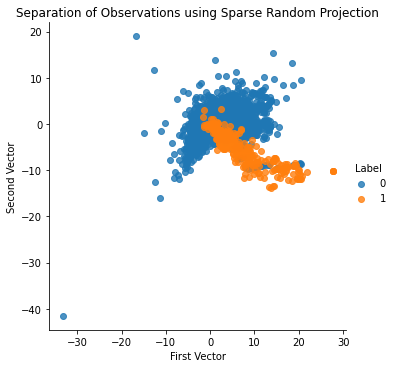

In [41]:
from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = .01
dense_output = True
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, 
                             density=density, 
                             eps=eps, 
                             dense_output=dense_output,
                             random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

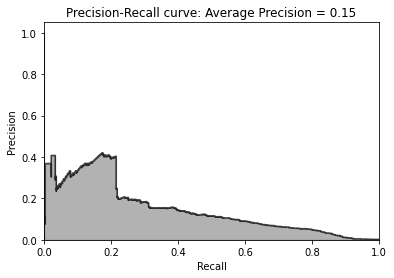

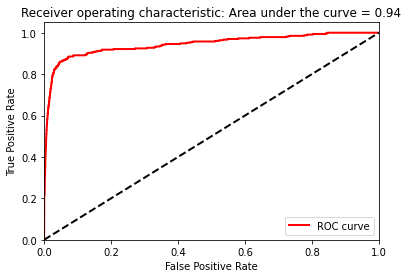

In [42]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomalyScores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

이상 탐지 시스템으로 활용하기에는 결과가 그다지 좋지 않은것을 확인할 수 있습니다.

### **2.비선형 이상치 탐지**

지난번에 배웠던 Isomap, MDS, lle, tsne등의 기법으로, sklearn.manifold 내부 함수로 구현되어 있습니다.

책에서는 이부분을 건너뛰었지만, 여기서는 커널 PCA에서 진행했던 것처럼 2천개 샘플만 가지고 훈련을 진행하도록 하겠습니다.

#### ISOMAP

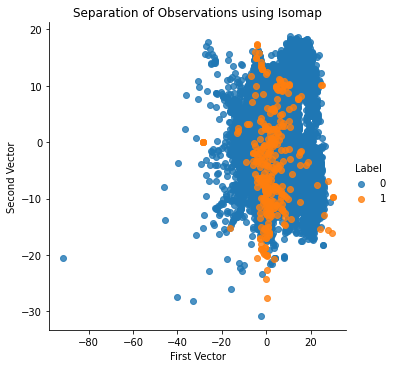

In [43]:
from sklearn.manifold import Isomap

n_components = 27

ISOMAP = Isomap(n_components=n_components)

X_train_ISOMAP = ISOMAP.fit(X_train.iloc[:2000])
X_train_ISOMAP = X_train_ISOMAP.transform(X_train)
X_train_ISOMAP = pd.DataFrame(data=X_train_ISOMAP, index=X_train.index)

scatterPlot(X_train_ISOMAP, y_train, "Isomap")

#### LLE

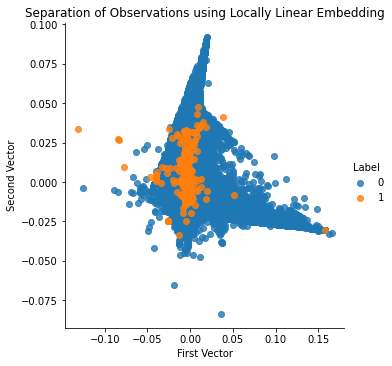

In [44]:
from sklearn.manifold import LocallyLinearEmbedding

n_components = 27
random_state = 2018

LLE = LocallyLinearEmbedding(n_components=n_components, random_state=random_state)

X_train_LLE = LLE.fit(X_train.iloc[:2000])
X_train_LLE = X_train_LLE.transform(X_train)
X_train_LLE = pd.DataFrame(data=X_train_LLE, index=X_train.index)

scatterPlot(X_train_LLE, y_train, "Locally Linear Embedding")

실행 속도도 매우 느리고, 성능도 좋지 않으며 사용하는 메모리 용량도 많기 때문에 사기 탐지 솔루션에 적합하지 않습니다.

### **3.사전 학습을 활용한 이상치 탐지**

사전 학습 모델은 batch size를 지정해 줄 수 있습니다. 

**batch size란?**

현재의 데이터 샘플 중 일정 부분 데이터 셋을 나누는 것을 말합니다. 예를 들어 700개의 데이터가 있을 때, batch_size를 100으로 지정해 주면 우리는 7개의 batch로 나눠서 학습을 진행할 수 있습니다.

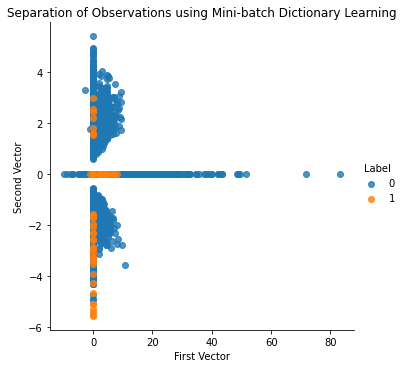

In [45]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train)
X_train_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = \
    pd.DataFrame(data=X_train_miniBatchDictLearning, index=X_train.index)

scatterPlot(X_train_miniBatchDictLearning, y_train, \
            "Mini-batch Dictionary Learning")

사전 학습 모델은 시각화를 통해서 이상을 잘 탐지하지 못한다는 사실을 알 수 있습니다.

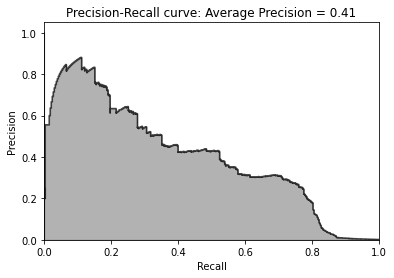

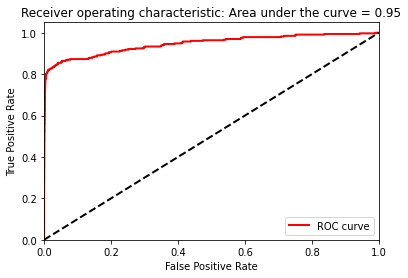

In [46]:
# View plot
X_train_miniBatchDictLearning_inverse = \
    np.array(X_train_miniBatchDictLearning). \
    dot(miniBatchDictLearning.components_)

X_train_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_train_miniBatchDictLearning_inverse, \
                 index=X_train.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_train, \
    X_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresMiniBatchDictLearning, True)

위 precision-Recall 그래프를 보더라도 이상 탐지에 좋은 성능을 보이지 않는 모델이라고 할 수 있습니다.

### **4.ICA를 활용한 이상치 탐지**

ICA란 독립 성분 분석(Independent Component Analysis, ICA)으로, 다변량의 신호를 통계적으로 독립적인 하부 성분으로 분리하는 계산 방법입니다.

ICA는 비선형 이상 탐지 기법이며, 일반 PCA와 동일하다. (주어진 데이터를 대표하는 기저벡터 찾아주기 때문이다)

일반 PCA와 ICA의 차이점:

- PCA: 우선순위 - 정사영시 분산 최대 벡터

- ICA: 우선순위 - 결과들이 최대한 독립적

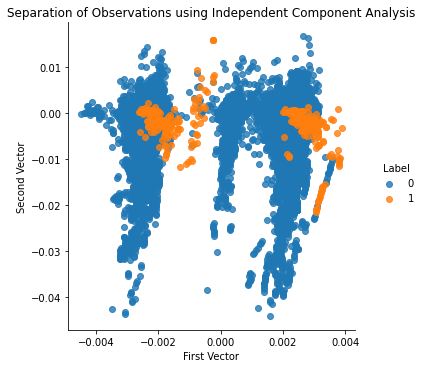

In [47]:
# 독립 성분 분석

from sklearn.decomposition import FastICA

n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2018

fastICA = FastICA(n_components=n_components, \
    algorithm=algorithm, whiten=whiten, max_iter=max_iter, \
    random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=X_train.index)

X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, \
                                       index=X_train.index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

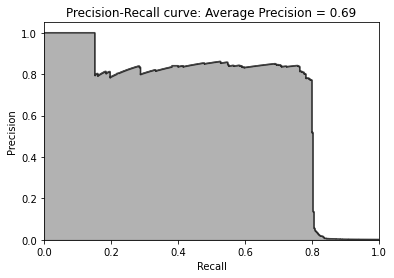

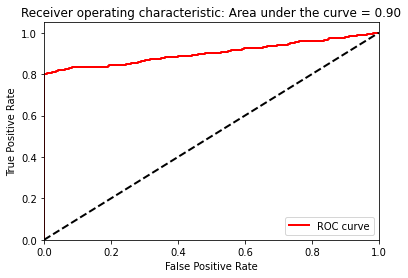

In [48]:
anomalyScoresFastICA = anomalyScores(X_train, X_train_fastICA_inverse)
preds = plotResults(y_train, anomalyScoresFastICA, True)

In [49]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.8
Fraud Caught out of 330 Cases: 264


ICA를 이용하여 이상치 탐지 모델을 만든 결과, PCA 모델처럼 평균 정밀도가 0.75이고 사기 거래의 80% 탐지가 가능한 것을 알 수 있습니다.

### **결론**

지금까지 추가적인 비지도 머신러닝 기반의 이상 탐지 기법들을 활용하여 사기 거래 탐지 모델을 만들어보고 결과를 비교해보았습니다.

이번에 시도한 이상치 탐지 기법중에서는 27개의 주성분을 이용한 ICA 기법을 이용하는 경우가 성능이 가장 좋았습니다.

다음 포스팅에는 '오토인코더 개념' 편으로 찾아뵙겠습니다.

😊감사합니다😊